<a href="https://colab.research.google.com/github/hannape/IBAC-Biodiv/blob/master/Transfer_learning_3types.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pierwsze próby transfer learningu. Pomysły:

1.   zastosowanie wag inicjalizujących ---> done
2.   zamrożenie całej sieci, podmiana tylko klasyfikatora (denseNety? average global pooling? SVMs?)
3.  zamrożenie części wag, douczenie reszty. Nie mam na razie pojęcia jak to zrobić i ile warstw zamrozić - i jak


Pierwsza część - wczytanie danych treningowych, testowych, przekopiowana z pamula.hania : project2_moje_zmiany_train_test.ipynb

wyczyszczone komentarze i niepotrzebne funkcje


In [1]:
from google.colab import drive
drive.mount('/content/drive')
from __future__ import print_function

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os

import librosa
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import roc_auc_score
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn import preprocessing
import wave
import contextlib
import math
from torchvision import models
import torch.nn as nn
import calendar
import time

# Wczytywanie Danych

In [0]:
path_test1618 = 'drive/My Drive/testowe_1618/'

def my_load_mel(samples, start=0, stop=None ):
    '''Wczytuje mel spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
        n_mels (int): Liczba meli na spektrogramie (wysokość spektrogramu).
    
    Returns:
        ndarray: Spektrogram.
    '''
    sample_rate = 44100
    n_mels= 60 ## -------------------------------------------------------------------- ZMIANA ze 128

    if(stop>np.shape(samples)[0]):

      stop = np.shape(samples)[0]
      #print("TUTEEEEEEEEEEJ")

      print((stop-start)/sample_rate)

    
    samples = samples[int(start):int(stop) if stop else None]
    if(np.shape(samples)[0] < sample_rate/2):
      #print("weszło w warunek")
      diff = sample_rate/2 - np.shape(samples)[0]
      samples = np.pad(samples, (0,int(diff)), 'constant', constant_values=(0))
      #print(np.shape(samples)[0])
      #print("PADY" + str(start)+ " , " + str(stop))

    spectrogram = librosa.feature.melspectrogram(y = samples, sr = sample_rate, n_fft=512, hop_length = 150,
                                                   n_mels = n_mels, fmin = 4000, fmax = 9500)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    #print(np.shape(spectrogram))
    return spectrogram


def my_check_voices(second, labels, tol=0.):
    '''Sprawdza czy w ramce czasowej [second, second+1] znajduje się głos według etykiet `labels`.
    
    Args:
        second (float): Sekunda nagrania.
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
        tol (float): Tolerancja na brzegach fragmentu. Dźwięk, żeby był uznany, musi się kończyć po czasie `second+tol`
            lub zaczynać przed czasem `second+1-tol`.
    Returns:
        bool: Czy w ramce czasowej jest odgłos ptaka.
 ''' 
    
    calls_to_cut = ['t', 't?', 't ','t  ', 'g', 'czapla', 'gh', 'g cz', 'puszczyk','gaski','g?','mewa?','zwierzak?','high freq','g niskie','??? mysz']
    
    return (float(labels[0]) >= second and float(labels[0]) < second + 0.5 - tol) or \
           (float(labels[1]) < second + 0.5 and float(labels[1]) > second + tol) or \
           (float(labels[0]) < second and float(labels[1]) > second + 0.5) and (labels[2] in calls_to_cut)


def my_read_labels(label_name,path_test1618):
    '''Wczytuje etykiety czasowe z pliku labels.txt w folderze train.
    
    Returns:
        ndarray: Tablica z etykietami czasowymi zawierająca kolumny: nr nagrania, sekunda początku dźwięku, sekunda końca dźwięku.
    '''
    labels = []
    with open(os.path.join(path_test1618, label_name + '.txt'), 'r') as file:
        text = file.read()
        for line in text.split('\n')[0:]:
            if len(line) > 1:
                start, stop, spec = line.split('\t')
                #print(start)
                start, stop, spec = float(start), float(stop), str(spec),
                labels.append([start, stop, spec])
    return np.array(labels)

  
def my_map_seconds_to_y(labels, recording_duration):  ## Chcemy 500 ms z 150 ms overlapem
    '''Tworzy etykiety dla każdej kolejnej sekundy 10-sekundowego nagrania. -1 oznacza niepewną etykietę (urwane dźwięki na brzegach).
    
    Args:
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
    Returns:
        ndarray: Tablica z binarnymi etykietami dla każdej z 10 sekund z możliwą niepewną etkietą -1.
    '''
    calls_to_cut = ['t', 't?', 't ','t  ', 'g', 'czapla', 'gh', 'g cz', 'puszczyk','gaski','g?','mewa?','zwierzak?','high freq','g niskie','??? mysz']
    
    
    chunk_length_ms = 500
    chunk_overlap = 150
    duration_in_ms = recording_duration*1000
    nr_of_chunks =  1 + (duration_in_ms - chunk_length_ms) / (chunk_length_ms - chunk_overlap)
    #print("chunksy!!")
    #print(nr_of_chunks)
    
    
    y = [0] * math.ceil(nr_of_chunks) #recording_duration 
    y_restrictive = [0] * math.ceil(nr_of_chunks) #* recording_duration
    for s in range(math.ceil(nr_of_chunks)):
        for l in labels:
            if my_check_voices(s*0.35, l):
                y[s] = 1
                #print(s*0.35)
                if l[2] in calls_to_cut:
                  y[s] = 0
                 # print("Labele1: " + l[2]) 
            if my_check_voices(s*0.35, l, 0.004): # 0.02
                y_restrictive[s] = 1
                if l[2] in calls_to_cut:
                  y_restrictive[s] = 0
                  #print("wyciety glos:")
                  #print(l[2])
                  
                 # print("Labele2: " + l[2]) 
        if y[s] != y_restrictive[s]:
            y[s] = 0 # -1 jeśli mniej niż 4 ms fragment, to zakładamy że tam go nie ma...          
   
    return y
  
  
def my_load_test(a, load_repr=my_load_mel):
    '''Wczytuje dane testowe, moje, długie nagrania.

    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.

    Returns:
        (ndarray, ndarray): Tablica z danymi treningowymi, tablica z binarnymi etykietami treningowymi.
    '''
    
    
    X_train, y_train = [], []
    samples, sample_rate2 = [], []
    rec_files = [file_name for file_name in sorted(os.listdir(path_test1618)) if file_name.endswith('.wav')]
    #print(rec_files)
    #print(rec_files[0])

    #for file_name in rec_files[a]: # range(0,3):# [a:a+10]
    file_name=rec_files[a]
    # zmiana indentu
    recording_id = (file_name.split('.')[0])
    print("------------Analiza nagrania: " + file_name + "-----------")
    fname = path_test1618 + file_name
    with contextlib.closing(wave.open(fname,'r')) as f:
        frames = f.getnframes()
        rate = f.getframerate()
        duration = frames / float(rate)
        recording_duration = math.ceil(duration)
        print("Czas trwania - w sekundach: " + str(recording_duration))
    
    #recording_labels = labels[labels[:, 0] == recording_id]
    #print("Przed my read labels")
    recording_labels = my_read_labels(recording_id,path_test1618)
    #print("Przed my map seconds to y")
    #print(np.shape(recording_labels))
    y_binary = my_map_seconds_to_y(recording_labels, duration)
    #print("Po my map seconds to y") 
  
    samples, sample_rate2 = librosa.core.load(fname, sr = None)
    #print("SAMPLE")
    #print(np.shape(samples))
    #print(np.shape(y_binary))
    for i, y in enumerate(y_binary):
        if y != -1:
            try:
                representation = load_repr(samples, start = i*15435 , stop = i*15435 + 22050)# start = i, stop = i + 1)
                if (i%5000==0):
                  end_time = datetime.datetime.now()
                  print(end_time - start_time)
                  print(np.shape(X_train),np.shape(y_train))
                  start_time == end_time
                X_train.append(representation)
                y_train.append(y)
            except ValueError:
                print('Error reading file', file_name)
            except TypeError:
                print('Unsupported type', file_name)
    print(np.shape(X_train),np.shape(y_train))  
    #    
    return np.array(X_train), np.array(y_train)

In [4]:
rec_files = [file_name for file_name in sorted(os.listdir(path_test1618)) if file_name.endswith('.wav')]
print(rec_files[0:3])


['BUK1_20180918$040704.wav', 'BUK1_20181011$001004.wav', 'BUK1_20181013$023504.wav']


In [0]:
## Funkcje do traina

def load_mel(file_name, start=0, stop=None, n_mels=128):
    '''Wczytuje mel spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
        n_mels (int): Liczba meli na spektrogramie (wysokość spektrogramu).
    
    Returns:
        ndarray: Spektrogram.
    '''
    samples, sample_rate = librosa.core.load(file_name, sr = None)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    spectrogram = librosa.feature.melspectrogram(y = samples, sr = sample_rate,
                                                 n_mels = n_mels, fmin = 4000, fmax = 9500)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    #print(np.shape(spectrogram))
    return spectrogram


def load_spec(file_name, start=0, stop=None):
    '''Wczytuje standardowy spektrogram z pliku.
    
    Args:
        file_name (str): Nazwa pliku z nagraniem.
        start (float): Sekunda, w której zaczyna się interesujący fragment.
        stop (float): Sekunda, w której kończy się interesujący fragment.
    
    Returns:
        ndarray: Spektrogram.
    '''
    sample_rate, samples = wavfile.read(file_name)
    samples = samples[int(start * sample_rate):int(stop * sample_rate) if stop else None]
    _, _, spectrogram = signal.spectrogram(samples, sample_rate)
    return spectrogram


def load_test(load_repr=load_mel):
    '''Wczytuje dane testowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        ndarray: Tablica z danymi testowymi.
    '''
    with open('drive/My Drive/top2/sampleSubmission.csv', 'r') as file:
        lines = file.read().split()[1:]
        sample_ids = [line.split(',')[0] for line in lines]
        samples = np.array([s.split('/') for s in sample_ids])
    
    X_test = []
    rec_files = sorted([file_name for file_name in os.listdir('drive/My Drive/test') 
                        if file_name.endswith('.wav')], key=lambda x: int(x.split('.')[0][3:]))
    for file_name in rec_files:
        recording_id = file_name.split('.')[0][3:]
        time_markers = samples[samples[:, 0] == recording_id, 1].astype(np.int)
        for t in time_markers:
            representation = load_repr(os.path.join('drive/My Drive/test', file_name), start = t, stop = t + 1)
            X_test.append(representation)
    return np.array(X_test)


def read_labels():
    '''Wczytuje etykiety czasowe z pliku labels.txt w folderze train.
    
    Returns:
        ndarray: Tablica z etykietami czasowymi zawierająca kolumny: nr nagrania, sekunda początku dźwięku, sekunda końca dźwięku.
    '''
    labels = []
    with open(os.path.join('drive/My Drive/train', 'labels.txt'), 'r') as file:
        text = file.read()
        for line in text.split('\n')[1:]:
            if len(line) > 1:
                rec, start, stop = line.split(',')
                rec, start, stop = int(rec[3:]), float(start), float(stop)
                labels.append([rec, start, stop])
    return np.array(labels)


def check_voices(second, labels, tol=0.):
    '''Sprawdza czy w ramce czasowej [second, second+1] znajduje się głos według etykiet `labels`.
    
    Args:
        second (float): Sekunda nagrania.
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
        tol (float): Tolerancja na brzegach fragmentu. Dźwięk, żeby był uznany, musi się kończyć po czasie `second+tol`
            lub zaczynać przed czasem `second+1-tol`.
    Returns:
        bool: Czy w ramce czasowej jest odgłos ptaka.
    '''
    return (labels[1] >= second and labels[1] < second + 1 - tol) or \
           (labels[2] < second + 1 and labels[2] > second + tol) or \
           (labels[1] < second and labels[2] > second + 1)


def map_seconds_to_y(labels):
    '''Tworzy etykiety dla każdej kolejnej sekundy 10-sekundowego nagrania. -1 oznacza niepewną etykietę (urwane dźwięki na brzegach).
    
    Args:
        labels (ndarray): Tablica z etykietami, której 2 kolumna oznacza początek, a 3-cia - koniec nagrania.
    Returns:
        ndarray: Tablica z binarnymi etykietami dla każdej z 10 sekund z możliwą niepewną etkietą -1.
    '''
    y = [0] * 10
    y_restrictive = [0] * 10
    for s in range(10):
        for l in labels:
            if check_voices(s, l):
                y[s] = 1
            if check_voices(s, l, 0.02):
                y_restrictive[s] = 1
        if y[s] != y_restrictive[s]:
            y[s] = -1
    return y


def load_train(load_repr=my_load_mel):
    '''Wczytuje dane treningowe.
    
    Args:
        load_repr (function): Funkcja wczytująca pożądaną reprezentację.
    
    Returns:
        (ndarray, ndarray): Tablica z danymi treningowymi, tablica z binarnymi etykietami treningowymi.
    '''
    path_train161718 = 'drive/My Drive/treningowe94_161718/'
    
    X_train, y_train = [], []
    
    rec_files = [file_name for file_name in os.listdir(path_train161718) if file_name.endswith('.wav')]
    years = ['2016','2017','2018']
    files_sorted = []

    for year in years:
      i_201x = [i for i,s in enumerate(rec_files) if year in s]
      n_201x = sorted(rec_files[index] for index in i_201x)
      files_sorted = files_sorted + n_201x
     
    rok = "6"
    for file_name in files_sorted:
       
        print("------------Analiza nagrania: " + file_name + "-----------")
        recording_id = str(file_name.split('.')[0])
        if (file_name=="BUK4_20171001_020404a.wav"):
          rok = "7"
        if (file_name=="BUK4_20181029_235604.wav"):
          rok = "8"  
        source_npz = "/content/drive/My Drive/nobirds_chunks/repr7_201" + rok + "/"
        ## wczytanie plików, skąd można wziąc nr próbek losowych do balanced dataset
        dane1 = np.load(source_npz + 'Kopia '+ recording_id + '_7rep.npz' )
        nobirds_chunks = dane1["nobirds_chunks"] 
        print(np.shape(nobirds_chunks)) 
        
        fname = path_train161718 + file_name
        with contextlib.closing(wave.open(fname,'r')) as f:
            frames = f.getnframes()
            rate = f.getframerate()
            duration = frames / float(rate)
            recording_duration = math.ceil(duration)
            print("Czas trwania - w sekundach: " + str(recording_duration))
            
      
      
        recording_id = (file_name.split('.')[0])
        print(recording_id)
        recording_labels = my_read_labels(recording_id, path_train161718)
        y_binary = my_map_seconds_to_y(recording_labels, duration)

        
        samples, sample_rate2 = librosa.core.load(fname, sr = None)
        
        for i, y in enumerate(y_binary):
            if y == 1:
                try:
                    representation = load_repr(samples, start = i*15435 , stop = i*15435 + 22050) #(os.path.join('drive/My Drive/treningowe94_161718', file_name), start = i, stop = i + 1)
                    X_train.append(representation)
                    y_train.append(y)
                except ValueError:
                    print('Error reading file', file_name)
                except TypeError:
                    print('Unsupported type', file_name)
        
        for i in nobirds_chunks:
            #if y == 1:
                try:
                    representation = load_repr(samples, start = i*15435 , stop = i*15435 + 22050) #(os.path.join('drive/My Drive/treningowe94_161718', file_name), start = i, stop = i + 1)
                    X_train.append(representation)
                    y_train.append(y)
                except ValueError:
                    print('Error reading file', file_name)
                except TypeError:
                    print('Unsupported type', file_name)
        print("Liczba no birds chunks: " + str(np.shape(nobirds_chunks)) + "Liczba positive chunks: " + str(sum(y_binary)))
        
        
        
        print(np.shape(X_train),np.shape(y_train)) 
    return np.array(X_train), np.array(y_train)

In [27]:
X_train_new, y_train_new = load_train()

print(X_train_new.shape)
print(y_train_new.shape)



------------Analiza nagrania: 1swierszcze_nakladki_BUK4_20160925_204604.wav-----------
(124,)
Czas trwania - w sekundach: 1799
1swierszcze_nakladki_BUK4_20160925_204604
Liczba no birds chunks: (124,)Liczba positive chunks: 125
(249, 60, 148) (249,)
------------Analiza nagrania: 2koniec_swierszczy_BUK4_20160925_221604.wav-----------
(65,)
Czas trwania - w sekundach: 1799
2koniec_swierszczy_BUK4_20160925_221604
Liczba no birds chunks: (65,)Liczba positive chunks: 66
(380, 60, 148) (380,)
------------Analiza nagrania: 3wzgledna_cisza_BUK4_20160925_224604.wav-----------
(110,)
Czas trwania - w sekundach: 1799
3wzgledna_cisza_BUK4_20160925_224604
Liczba no birds chunks: (110,)Liczba positive chunks: 111
(601, 60, 148) (601,)
------------Analiza nagrania: 4szum_sredni_BUK4_20160918_013604.wav-----------
(50,)
Czas trwania - w sekundach: 1799
4szum_sredni_BUK4_20160918_013604
Liczba no birds chunks: (50,)Liczba positive chunks: 16
(667, 60, 148) (667,)
------------Analiza nagrania: 5szum_sred

# Model i Trenowanie

In [35]:
# Dzielenie zbioru danych na treningowy i walidacyjny
#split_point = int(len(X) * 0.8)
import sklearn
X_train1, X_val1, y_train1, y_val1 = sklearn.model_selection.train_test_split(X_train_new, y_train_new, test_size=0.2, random_state=667)

stacked_X_train1 = np.stack(3*(X_train1,), axis=1)
stacked_X_val1 = np.stack(3*(X_val1,), axis=1)

X_train = torch.Tensor(stacked_X_train1) #X[:split_point])
#X_train = torch.Tensor(X_train1) #X[:split_point])
y_train = torch.LongTensor(y_train1) #[:split_point])
print(np.shape(y_train))
print(np.shape(X_train))
X_valid = torch.Tensor(stacked_X_val1) #[split_point:])
#X_valid = torch.Tensor(X_val1) #[split_point:])
y_valid = torch.LongTensor(y_val1) #[split_point:])
print(np.shape(y_valid))
print(np.shape(X_valid))
batch_size = 64

dataset = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_data_loader = DataLoader(valid_dataset, batch_size = batch_size)

torch.Size([12732])
torch.Size([12732, 3, 60, 148])
torch.Size([3184])
torch.Size([3184, 3, 60, 148])


In [0]:
#@title
import torch
import torch.nn as nn
#from .utils import load_state_dict_from_url
from torch.hub import load_state_dict_from_url

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

# kopia architektury resnet z biblioteki pytorch (licencja cc) https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False, # <<<<<<<<<<<<<<<<<<<< zmiana na 2 klasy  !!!! 1000
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)  # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< konwersja na 1 kanał !!!!!!!!3
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)   # torch.flatten(x, 1)
        x = self.fc(x)

        return x

def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                      **kwargs)    

#clf = resnet18(pretrained=True)#.cuda()
#clf = ResNet(BasicBlock, [2, 2, 2, 2])#.cuda()

In [0]:
######### OPCJA 1 - inicjalizujemy wagami, ale uczymy całą sieć od nowa. Stosowane w przypadku gdy dużo dancyh, i gdy dane podobne do zbioru transferowanego
## ft: FINE - TUNING
## https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

model_ft = models.resnet18(pretrained=True)
#print(model_ft)
num_ftrs = model_ft.fc.in_features  # fc- fully connected, input features
model_ft.fc = nn.Linear(num_ftrs, 2)
#print(model_ft)


In [0]:
######### OPCJA 2 - inicjalizujemy i zamrażamy wszystkie wagi oprócz ostatniej warstwy która będzie trenowana

feature_extract_last = models.resnet18(pretrained=True)
for param in feature_extract_last.parameters():
    param.requires_grad = False

num_ftrs = feature_extract_last.fc.in_features
feature_extract_last.fc = nn.Linear(num_ftrs, 2)
#print(feature_extract_last)


In [0]:
######### OPCJA 3 - inicjalizujemy i zamrażamy wszystkie wagi oprócz kilku ostatnich warstw które będą retrenowane
# https://towardsdatascience.com/transfer-learning-picking-the-right-pre-trained-model-for-your-problem-bac69b488d16

feature_extract_few = models.resnet18(pretrained=True)

count = 0
'''
for name, child in feature_extract_few.named_children(): 
   count+=1
   if count < 7:    
     for param in child.parameters():
        param.requires_grad = False
'''
for name, child in feature_extract_few.named_children():
    if name in ['layer3', 'layer4']:
        print(name + ' has been unfrozen.')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

num_ftrs = feature_extract_few.fc.in_features
feature_extract_few.fc = nn.Linear(num_ftrs, 2)
#print(feature_extract_few)


In [0]:
######### OPCJA 4 - inicjalizujemy i zamrażamy pierwszą warstwę, reszta retrenowane
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# https://towardsdatascience.com/transfer-learning-picking-the-right-pre-trained-model-for-your-problem-bac69b488d16
# https://stackabuse.com/image-classification-with-transfer-learning-and-pytorch/#fixedfeatureextractor

feature_extract_first = models.resnet18(pretrained=True)

count = 0
'''
for name, child in feature_extract_few.named_children(): 
   count+=1
   if count < 7:    
     for param in child.parameters():
        param.requires_grad = False
'''
for name, child in feature_extract_first.named_children():
    if name in ['layer2','layer3', 'layer4']:
        print(name + ' has been unfrozen.')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

num_ftrs = feature_extract_first.fc.in_features
feature_extract_first.fc = nn.Linear(num_ftrs, 2)
#print(feature_extract_few)

In [0]:
######### OPCJA 5 - ResNet50, 3,4 odmrożone
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# https://towardsdatascience.com/transfer-learning-picking-the-right-pre-trained-model-for-your-problem-bac69b488d16
# https://stackabuse.com/image-classification-with-transfer-learning-and-pytorch/#fixedfeatureextractor

feature_extract_res50 = models.resnet50(pretrained=True)

count = 0

for name, child in feature_extract_res50.named_children(): 
  #print(name)
  '''
  for name, child in feature_extract_few.named_children(): 
    count+=1
    if count < 7:    
      for param in child.parameters():
          param.requires_grad = False
  '''

for name, child in feature_extract_res50.named_children():
    if name in ['layer3', 'layer4']:
       # print(name + ' has been unfrozen.')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False
num_ftrs = feature_extract_res50.fc.in_features
feature_extract_res50.fc = nn.Linear(num_ftrs, 2)
#print(feature_extract_few)

In [0]:
######### OPCJA 6 - inicjalizujemy wagami, ale uczymy całą sieć od nowa. Stosowane w przypadku gdy dużo dancyh, i gdy dane podobne do zbioru transferowanego
## ft: FINE - TUNING

model_ft50 = models.resnet50(pretrained=True)
num_ftrs = model_ft50.fc.in_features  # fc- fully connected, input features
model_ft50.fc = nn.Linear(num_ftrs, 2)


In [0]:
######### OPCJA 7 - nieinicjalizujemy wagami, bierzemy tylko architekturę. Dla porównania
## ft: FINE - TUNING

model_arch = models.resnet18(pretrained=False)
num_ftrs = model_arch.fc.in_features  # fc- fully connected, input features
model_arch.fc = nn.Linear(num_ftrs, 2)


In [0]:
#@title
print(X_train.numpy()[0].shape)

img = X_train.numpy() #np.array([[1, 2], [3, 4]])
print(np.shape(img))
stacked_img = np.stack(3*(img,), axis=1)
#print(np.shape(stacked_img))
#print(stacked_img[0,0,2,1])
#print(stacked_img[0,1,2,1])
#print(stacked_img[0,2,2,1])

In [0]:
opcja = [model_ft, feature_extract_last, feature_extract_few, feature_extract_first, feature_extract_res50, model_ft50, model_arch]
opcja_nr = 6;

In [37]:

ts = calendar.timegm(time.gmtime())


#for clf in opcja[opcja_nr]:

for run in range(3):
    start_time =  time.time()
    losses, scores = [], []
    epoch = 0
    #clf = ResNet(BasicBlock, [2, 2, 2, 2]).cuda()
    #clf = model_ft
    clf=opcja[opcja_nr]
    # Ustawienie kosztu i optimizera
    criterion = torch.nn.CrossEntropyLoss()
    ''' if (opcja_nr==0 || opcja_nr==0):
      optimizer = torch.optim.Adam(clf.parameters())
      print("opcja 0 ft")
    if opcja_nr==1:
      optimizer = torch.optim.Adam(clf.fc.parameters())
      print("opcja 1 ffe last")
    if opcja_nr>1:'''
    optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, clf.parameters()))
    print("opcja "+ str(opcja_nr)) # + " ffe few")  

    # Pętla uczenia
    best_preds, best_score = None, 0.
    batches = X_train.shape[0]//64
    torch.set_num_threads(55)

    for epoch in range(15):
        running_loss = 0
        clf.train()
        clf.cuda()
        batch = 0
        for X, y in data_loader:
            #X = X[:,None,:,:]
            batch = batch+1
            #print(np.shape(X))
            optimizer.zero_grad()

            outputs = clf(X.cuda())
            loss = criterion(outputs, y.cuda())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        losses.append(running_loss)

        clf.eval()
        preds = []
        for X, _ in valid_data_loader:
            #X = X[:,None,:,:]
            out = clf(X.cuda())
            preds.append(torch.softmax(out, dim = 1)[:, 1].cpu().detach().numpy())
        preds = np.concatenate(preds, axis = 0)

        # Metryką testującą jest ROC AUC
        score = roc_auc_score(y_valid.numpy(), preds)
        #print(score)
        scores.append(score)
        print('Epoch:', epoch+1, 'Batch', batch+1, '/', batches, 'Score:', score, 'Loss', running_loss)
        if score > best_score:
            best_score = score
            best_preds = preds
            #np.save('tmp_preds', best_preds)

            # Model dający najlepszy wynik powinien być zapisany
            torch.save(clf.state_dict(), 'tmp_model.pt')
            
    print(run, "score", best_score)
    if best_score > 0.8:
        print('Saving')
        state = torch.load('tmp_model.pt')
        t = "drive/My Drive/models/transfer_learning_manytypes/" + str(opcja_nr) + "_" + str(epoch+1) + "_"+ str(ts)
        os.makedirs(t, exist_ok=True)
        torch.save(state, t + '/run_' + str(run) + '_' + str(best_score) + '.pt')
    end = time.time()
    print(end - start_time)    



opcja 6
Epoch: 1 Batch 200 / 198 Score: 0.9227724030978371 Loss 88.14711099863052
Epoch: 2 Batch 200 / 198 Score: 0.9434118847281181 Loss 59.65788486599922
Epoch: 3 Batch 200 / 198 Score: 0.9576151739690721 Loss 49.664963975548744
Epoch: 4 Batch 200 / 198 Score: 0.9624934461542349 Loss 44.03011690080166
Epoch: 5 Batch 200 / 198 Score: 0.9636443172629878 Loss 41.306270245462656
Epoch: 6 Batch 200 / 198 Score: 0.9514304755407317 Loss 38.55257127061486
Epoch: 7 Batch 200 / 198 Score: 0.9567726494592683 Loss 35.79466649889946
Epoch: 8 Batch 200 / 198 Score: 0.9640039891600971 Loss 33.06233999878168
Epoch: 9 Batch 200 / 198 Score: 0.963359264453204 Loss 31.580199437215924
Epoch: 10 Batch 200 / 198 Score: 0.9574596188346471 Loss 27.47874783910811
Epoch: 11 Batch 200 / 198 Score: 0.96106640546038 Loss 25.878767620772123
Epoch: 12 Batch 200 / 198 Score: 0.9589549616560542 Loss 22.192395848222077
Epoch: 13 Batch 200 / 198 Score: 0.9587210367394381 Loss 19.466550381854177
Epoch: 14 Batch 200 / 1

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Best score 0.9570687569486558


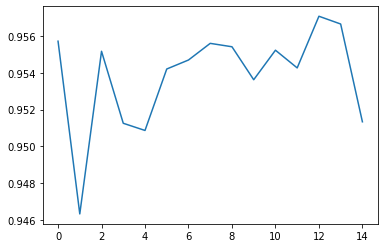

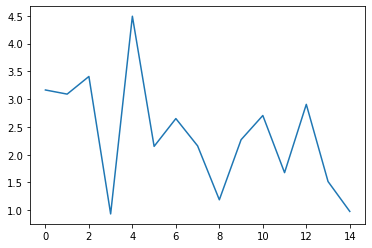

In [38]:
# Rysowanie lossu i AUC

import matplotlib.pyplot as plt

%matplotlib inline

print('Best score', best_score)

plt.plot(scores)
plt.show()

plt.plot(losses)
plt.show()

# Predykcja


In [29]:
rec_files = [file_name for file_name in sorted(os.listdir(path_test1618)) if file_name.endswith('.wav')]
print(rec_files)
print(rec_files[0])

file_name=rec_files[0]
print(file_name)

['BUK1_20180918$040704.wav', 'BUK1_20181011$001004.wav', 'BUK1_20181013$023504.wav', 'BUK4_20160922_005604.wav', 'BUK4_20161008_004605.wav', 'BUK4_20161016_012704.wav', 'BUK4_20161016_035704.wav', 'BUK4_20180913_201703.wav', 'BUK4_20180925_224703.wav', 'BUK5_20161101_002104a.wav', 'BUK5_20161101_002104b.wav', 'BUK5_20180909_010005.wav', 'BUK5_20180921_015906a.wav', 'BUK5_20180921_015906b.wav', 'BUK5_20181010_011205.wav', 'BUK5_20181014_233005.wav', 'BUK5_20181020_014805a.wav', 'BUK5_20181021_004605deszczyk.wav', 'BUK5_20181028_043105.wav', 'BUK5_20181103_011804.wav']
BUK1_20180918$040704.wav
BUK1_20180918$040704.wav


In [30]:
model_path="drive/My Drive/models/transfer_learning_manytypes/"
opcja_nr = 1
clf=opcja[opcja_nr]
pliki = [x for x in (os.listdir(model_path)) if x.startswith(str(opcja_nr))]
print(model_path + str(pliki[0])+"/")

drive/My Drive/models/transfer_learning_manytypes/1_15_1573645681/


In [31]:
au=[]
ensambled_models = [x for x in (os.listdir(model_path + str(pliki[0]+'/'))) if not x.startswith('.')]
print(ensambled_models)

for i in range(0,np.shape(ensambled_models)[0]):
   zero_pos= ensambled_models[:][i].find('0.')
   auc_mod = (ensambled_models[:][i][zero_pos:zero_pos+7])
   au.extend([auc_mod])
print(au)  

ind1 = np.argpartition(au, 0)[-1:]
ind3 = np.argpartition(au, 0)[-3:]
ind5 = np.argpartition(au, 0)[-5:]
#ind15 = np.argpartition(au, 0)[-15:]
print(ind5)

['run_0_0.8482119450550838.pt', 'run_1_0.8465653900090964.pt', 'run_2_0.8465782213336365.pt']
['0.84821', '0.84656', '0.84657']
[1 2 0]


In [0]:
#@title
print(X_test1.shape)
X_test = np.array([])
#X_test = np.empty([5137,3,60,148])
y_tests=[]
y_tests = np.concatenate((y_tests,y_test1), axis = 0)
print(np.shape(y_test1))
print(np.shape(y_tests))
X_test = np.vstack([X_test,X_test1]) if X_test.size else X_test1 #np.concatenate((X_test,X_test1), axis = 0)
print(np.shape(X_test))

In [0]:
#@title
import datetime
start_time = datetime.datetime.now()
X_test = np.array([])
y_tests=[]
for k in range(0,20):
    print("nagranie" + str(k+1))
    X_test1, y_test1 = my_load_test(k)
    
    print(np.shape(X_test1))
    # na 3d
    X_test1 = np.stack(3*(X_test1,), axis=1)
    print(np.shape(X_test1))
    X_test = np.vstack([X_test,X_test1]) if X_test.size else X_test1 #np.concatenate((X_test,X_test1), axis = 0)
    y_tests = np.concatenate((y_tests,y_test1), axis = 0)
print(np.shape(X_test))
print(np.shape(y_test))    

In [0]:
#@title
## pojedynczo

import datetime
start_time = datetime.datetime.now()
batch_size = 64

y_tests=[]
predictions1=[]
predictions3=[]


for i in range(0,20): 
  clf.cuda()
  preds_ind1 = []
  preds_ind3 = []
  #X_test = np.array([])
  y_test = []
  print("___________RZUT: " + str(i+1) + "______________")
  #preds_ind5=[]
  #for k in range(i*5,(i+1)*5):
    #print("nagranie" + str(k+1))
  X_test1, y_test1 = my_load_test(i)
  
  #print(np.shape(X_test1))
  # na 3d
  X_test1 = np.stack(3*(X_test1,), axis=1)
    #print(np.shape(X_test1))
    #X_test = np.vstack([X_test,X_test1]) if X_test.size else X_test1 #np.concatenate((X_test,X_test1), axis = 0)
  y_tests = np.concatenate((y_tests,y_test1), axis = 0)
  #  print(np.shape(X_test))
  #print("piatka")
  print(np.shape(X_test))
  print(np.shape(y_tests))
  #print("prawdziwa etykieta !!!!!!!!!!" +str(y_tests[0]))

  # Tworzenie data loadera testowego
  X_test_tensor = torch.Tensor(X_test1)
  print(np.shape(X_test_tensor))
  rozmiar =np.shape(X_test_tensor)[0]
  test_dataset = TensorDataset(X_test_tensor)
  test_data_loader = DataLoader(test_dataset, batch_size = batch_size)
  y_tests = np.concatenate((y_tests,y_test), axis = 0)

  for j in ind3:
  
    model_name = ensambled_models[j]
    clf.load_state_dict(torch.load(model_path + str(pliki[0]+'/') + model_name))
    print("Wczytujemy model ",model_name)
    clf.eval()
    pred = []
    #print(i)
    for X in test_data_loader:
        X = X[0]
        #X = X[:,None,:,:]
        out = clf(X.cuda())
        pred.append(torch.softmax(out, dim = 1)[:, 1].cpu().detach().numpy())
    pred = np.concatenate(pred, axis = 0)
    print("predykcja !!!!!!!!!!" +str(pred[0]))
   #preds_ind5 = np.concatenate((preds_ind5,pred), axis = 0)
    if j in ind3:
      preds_ind3 = np.concatenate((preds_ind3,pred), axis = 0)
      print("do 3 naj")
    if j in ind1:  
      preds_ind1 = np.concatenate((preds_ind1,pred), axis = 0)
      print("Naj")
    #preds = np.stack((preds,pred), axis = 0)
    
    print("wewn petla")
    print(np.shape(preds),np.shape(y_tests))

  
  print("zewn petla")
  #preds5 = (preds_ind5.reshape(len(ind5),rozmiar)).mean(axis=0)
  preds3 = (preds_ind3.reshape(len(ind3),rozmiar)).mean(axis=0)
  #print(np.shape(preds5))
  print(np.shape(preds3))
  #preds = preds.mean(axis=0)
  #print(np.shape(preds))
  #predictions5 = np.concatenate((predictions5,preds5), axis = 0)  
  predictions3 = np.concatenate((predictions3,preds3), axis = 0) 
  predictions1 = np.concatenate((predictions1,preds_ind1), axis = 0) 
  print(np.shape(predictions3),np.shape(predictions1)) #np.shape(predictions5),
  print('____________________________')
  score3 = roc_auc_score(y_tests,predictions3) # mean_pred_res)
  print('3mdl:' + str(score3))
  score1 = roc_auc_score(y_tests,predictions1) # mean_pred_res)
  print('Best mdl:' + str(score1))


#mean_pred = np.stack(predictions).mean(axis=1)
#mean_pred_res = np.squeeze(mean_pred.reshape(1,np.shape(mean_pred)[0]*np.shape(mean_pred)[1])) # nieładnie zreshapowane.


In [0]:
#@title
print(opcja_nr)
score3 = roc_auc_score(y_tests,predictions3) # mean_pred_res)
print(score3)
score1 = roc_auc_score(y_tests,predictions1) # mean_pred_res)
print(score1)

In [32]:
## w paczkach po 5. 
import datetime
start_time = datetime.datetime.now()
batch_size = 64
#clf.load_state_dict(torch.load('drive/My Drive/models/transfer_learning1/1573052648/run_0_0.960145511168385.pt'))

y_tests=[]
predictions1=[]
predictions3=[]
#predictions5=[]

ensembling = ind3


for i in range(0,4): # trzeba podzielić na 4 bo RAM nie łyka tego.
  clf.cuda()
  preds_ind1 = []
  preds_ind3 = []
  X_test = np.array([])
  y_test = []
  print("___________RZUT: " + str(i+1) + "______________")
  #preds_ind5=[]
  for k in range(i*5,(i+1)*5):
    print("nagranie" + str(k+1))
    X_test1, y_test1 = my_load_test(k)
    
    print(np.shape(X_test1))
    # na 3d
    X_test1 = np.stack(3*(X_test1,), axis=1)
    print(np.shape(X_test1))
    X_test = np.vstack([X_test,X_test1]) if X_test.size else X_test1 #np.concatenate((X_test,X_test1), axis = 0)
    y_tests = np.concatenate((y_tests,y_test1), axis = 0)
    print(np.shape(X_test))
  print("piatka")
  print(np.shape(X_test))
  print(np.shape(y_tests))
  print("prawdziwa etykieta !!!!!!!!!!" +str(y_tests[0]))

  # Tworzenie data loadera testowego
  X_test_tensor = torch.Tensor(X_test)
  print(np.shape(X_test_tensor))
  rozmiar =np.shape(X_test_tensor)[0]
  test_dataset = TensorDataset(X_test_tensor)
  test_data_loader = DataLoader(test_dataset, batch_size = batch_size)
  #y_tests = np.concatenate((y_tests,y_test), axis = 0)

  for j in ind3:
  
    model_name = ensambled_models[j]
    clf.load_state_dict(torch.load(model_path + str(pliki[0]+'/') + model_name))
    print("Wczytujemy model ",model_name)
    clf.eval()
    pred = []
    #print(i)
    for X in test_data_loader:
        X = X[0]
        #X = X[:,None,:,:]
        out = clf(X.cuda())
        pred.append(torch.softmax(out, dim = 1)[:, 1].cpu().detach().numpy())
    pred = np.concatenate(pred, axis = 0)
    print("predykcja !!!!!!!!!!" +str(pred[0]))
   #preds_ind5 = np.concatenate((preds_ind5,pred), axis = 0)
    if j in ind3:
      preds_ind3 = np.concatenate((preds_ind3,pred), axis = 0)
      print("do 3 naj")
    if j in ind1:  
      preds_ind1 = np.concatenate((preds_ind1,pred), axis = 0)
      print("Naj")
    #preds = np.stack((preds,pred), axis = 0)
    
    print("wewn petla")
    print(np.shape(pred),np.shape(y_tests))

  
  print("zewn petla")
  #preds5 = (preds_ind5.reshape(len(ind5),rozmiar)).mean(axis=0)
  preds3 = (preds_ind3.reshape(len(ind3),rozmiar)).mean(axis=0)
  #print(np.shape(preds5))
  print(np.shape(preds3))
  #preds = preds.mean(axis=0)
  #print(np.shape(preds))
  #predictions5 = np.concatenate((predictions5,preds5), axis = 0)  
  predictions3 = np.concatenate((predictions3,preds3), axis = 0) 
  predictions1 = np.concatenate((predictions1,preds_ind1), axis = 0) 
  print(np.shape(predictions3),np.shape(predictions1)) #np.shape(predictions5),
  print('____________________________')
  score3 = roc_auc_score(y_tests,predictions3) # mean_pred_res)
  print('3mdl:' + str(score3))
  score1 = roc_auc_score(y_tests,predictions1) # mean_pred_res)
  print('Best mdl:' + str(score1))
  print('____________________________')


#mean_pred = np.stack(predictions).mean(axis=1)
#mean_pred_res = np.squeeze(mean_pred.reshape(1,np.shape(mean_pred)[0]*np.shape(mean_pred)[1])) # nieładnie zreshapowane.


___________RZUT: 1______________
nagranie1
------------Analiza nagrania: BUK1_20180918$040704.wav-----------
Czas trwania - w sekundach: 1799
0:00:05.567084
(0,) (0,)
0:00:25.563559
(5000, 60, 148) (5000,)
0.40235827664399093
(5137, 60, 148) (5137,)
(5137, 60, 148)
(5137, 3, 60, 148)
(5137, 3, 60, 148)
nagranie2
------------Analiza nagrania: BUK1_20181011$001004.wav-----------
Czas trwania - w sekundach: 1799
0:00:35.554708
(0,) (0,)
0:00:54.894417
(5000, 60, 148) (5000,)
0.40235827664399093
(5137, 60, 148) (5137,)
(5137, 60, 148)
(5137, 3, 60, 148)
(10274, 3, 60, 148)
nagranie3
------------Analiza nagrania: BUK1_20181013$023504.wav-----------
Czas trwania - w sekundach: 1799
0:01:03.658241
(0,) (0,)
0:01:23.716596
(5000, 60, 148) (5000,)
0.40235827664399093
(5137, 60, 148) (5137,)
(5137, 60, 148)
(5137, 3, 60, 148)
(15411, 3, 60, 148)
nagranie4
------------Analiza nagrania: BUK4_20160922_005604.wav-----------
Czas trwania - w sekundach: 1799
0:01:33.318637
(0,) (0,)
0:01:52.626716
(50

In [33]:
#score5 = roc_auc_score(y_tests,predictions5) # mean_pred_res)
#print(score5)
print(opcja_nr)
score3 = roc_auc_score(y_tests,predictions3) # mean_pred_res)
print(score3)
score1 = roc_auc_score(y_tests,predictions1) # mean_pred_res)
print(score1)

1
0.7583962230813471
0.7572488625089544


In [0]:
from sklearn.metrics import roc_curve
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import os
import matplotlib
from scipy import interp

font = {'family' : 'normal',
        'size'   : 26}

matplotlib.rc('font', **font)

base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(7,7))
score_per = score3*100
fpr, tpr, thresholds = roc_curve(y_tests, predictions3)
plt.plot(fpr,tpr)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.title("ROC curve for ResNet model")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(["AUC: %.1f%%" % score_per],loc = 'lower right')